In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
print(holdout.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def run_all(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ['Age_categories','Fare_categories','Title','Cabin_type','Sex']
    for col in cols:
        df = create_dummies(df,col)
    return df
train = run_all(train)
holdout = run_all(holdout)

In [4]:
import numpy as np
np.dtype(train['SibSp'])

dtype('int64')

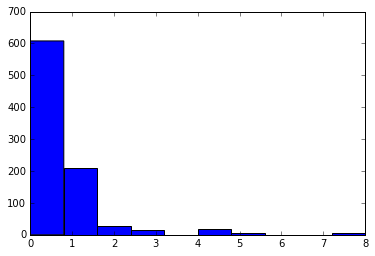

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(train['SibSp'])
plt.show()

In [6]:
train.pivot_table(index=['SibSp','Parch'],values='Survived')

SibSp  Parch
0      0        0.303538
       1        0.657895
       2        0.724138
       3        1.000000
       4        0.000000
       5        0.000000
1      0        0.520325
       1        0.596491
       2        0.631579
       3        0.333333
       4        0.000000
       5        0.333333
       6        0.000000
2      0        0.250000
       1        0.857143
       2        0.500000
       3        1.000000
3      0        1.000000
       1        0.000000
       2        0.285714
4      1        0.000000
       2        0.333333
5      2        0.000000
8      2        0.000000
Name: Survived, dtype: float64

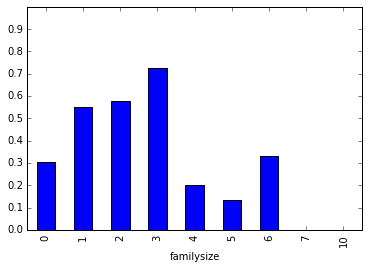

In [7]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=['familysize'],values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [8]:
def is_alone(df):
    df['familysize'] = df['SibSp'] + df['Parch']
    df['isalone'] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

In [9]:
train = is_alone(train)
holdout = is_alone(holdout)

In [10]:
cols = ['SibSp','Parch','isalone']
print(train[cols].head())
print(holdout[cols].head())

   SibSp  Parch  isalone
0      1      0        0
1      1      0        0
2      0      0        1
3      1      0        0
4      0      0        1
   SibSp  Parch  isalone
0      0      0        1
1      1      0        0
2      0      0        1
3      0      0        1
4      1      1        0


In [11]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [15]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X, all_y)
    cols = all_X.columns[selector.support_]
    print(cols)
    return cols
cols = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
def select_model(df, cols):
    all_X = df[cols]
    all_y = df['Survived']
    dict_1 = {
                'name':'LogisticRegression',
                'estimator':LogisticRegression(),
                'hyperparameter':{
                                     'solver':['newton-cg','lbfgs','liblinear']
                                  }
             }
    dict_2 = {
                "name": "KNeighborsClassifier",
                "estimator": KNeighborsClassifier(),
                "hyperparameter":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
             }
    dict_3 = {
                'name':'RandomForestClassifier',
                'estimator': RandomForestClassifier(random_state=1),
                'hyperparameter':{
                                    'n_estimators':[4,6,9],
                                    'criterion':['entropy','gini'],
                                    'max_depth':[2,5,10],
                                    'max_features':['log2','sqrt'],
                                    'min_samples_leaf':[1,5,8],
                                    'min_samples_split':[2,3,5]
                                 }
                }
    haha = [dict_1,dict_2,dict_3]
    for dictionary in haha:
        print(dictionary['name'])
        grid = GridSearchCV(dictionary['estimator'],
                            param_grid = dictionary['hyperparameter'],
                            cv=10)
        grid.fit(all_X,all_y)
        dictionary['best_param'] = grid.best_params_
        print(dictionary['best_param'])
        dictionary['best_score'] = grid.best_score_
        print(dictionary['best_score'])
        dictionary['best_model'] = grid.best_estimator_
        print(dictionary['best_model'])
    return haha


In [27]:
optimazed_dic_list = select_model(train,cols)

LogisticRegression
{'solver': 'liblinear'}
0.820426487093
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
KNeighborsClassifier
{'weights': 'uniform', 'algorithm': 'brute', 'n_neighbors': 5, 'p': 1}
0.775533108866
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')
RandomForestClassifier
{'max_depth': 5, 'criterion': 'entropy', 'n_estimators': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'min_samples_split': 5}
0.829405162738
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5,

In [30]:
def save_submission_file(model,cols,name):
    predictions = model.predict(holdout[cols])
    submission = pd.DataFrame({'PassengerId':holdout['PassengerId'],'Survived':predictions})
    sub = submission.to_csv(name,index=False)
best_model = optimazed_dic_list[2]['best_model']
save_submission_file(best_model,cols,'haha')